# Improving Speech Audio Quality on Edge Devices with Lightweight Latent Diffusion Models

Kevin Putra Santoso - Avalon AI - Institut Teknologi Sepuluh Nopember<br>
August, 13th 2024
<hr>
In this research, we introduce LLDM (Lightweight Latent Diffusion Models), specifically designed for audio denoising and restoration on edge devices. LLDM is heavily inspired by AudioLDMs (Hao et al., 2023) and utilizes Linear Attention Mechanisms along with Latent Diffusion Models to generate audio mel spectrograms. The diffusion model is conditioned on corrupted audio, with the goal of restoring it to its original, high-fidelity state (44.1 kHz).
<br>
<br>

To achieve this, we employ a $\phi$-probability spectrogram data loading strategy during training. In this setup, there is a $\phi$ probability that the dataloader will provide a corrupted spectrogram to the LLDM for inference, and a $1-\phi$ probability that it will supply a normal audio sample. This approach is designed to enable LLDM to effectively reconstruct the corrupted audio back to its original form through the diffusion process in the latent feature maps, before decoding it back into the original spectrogram.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T_ta
from datasets import Dataset 
from torch.utils.data import DataLoader
import torch.multiprocessing as mp
import numpy as np
import librosa
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from fastapi import FastAPI, Request
from tensorboardX import SummaryWriter
from pyngrok import ngrok
import uvicorn

from lldm.vae.enc_dec import AutoencoderKL
from lldm.util import get_padding_sample
from lldm.dataloader import LLDMDataset, collate_fn
from lldm.vae.discriminator import Discriminator
from lldm.trainer.loss_fn import GeneratorLoss, DiscriminatorLoss
from lldm.trainer.trainer_module import Trainer
from lldm.trainer.scheduler import CycleScheduler
from lldm.util import dynamic_range_compression, dynamic_range_decompression, count_parameters

device = "cuda" if torch.cuda.is_available() else "cpu"

## PART 1: Building and Training the VAE

Disini muncullah beberapa kondisi:
1. Syarat agar loss dapat dihitung adalah ukuran input dan output haruslah sama (not necessary ke semua data)
2. Karena ini bukan autoencoder, melainkan VAE, maka loss yang digunakan adalah KL loss, reconstruction loss, serta discriminator loss untuk membuat kualitasnya semakin realistis
3. Sepakat menggunakan log mel spectogram, ingat bahwa spektogram yang dibuat oleh log mel spectogram tidak dapat diinvers dengan mudah (suaranya akan pecah). Ini mungkin jika kita hanya menggunakan STFT dan melakukan invers menggunakan algoritma Griffin-lim.
4. Kita dapat menghitung ukuran lebar dari spektogram dengan menggunakan formula berikut. Jika diketahui dua buah audio merupakan audio identik dengan audio pertama memiliki sample rate sebesar $s_{low}$ , dan audio kedua memiliki sample rate $s_{hi}$, maka:
   - Jumlah sampel dapat dihitung: $ n_{sample} = s \cdot t $, dengan $s$ adalah sample rate dan $t$ adalah durasi audio.
   - Rasio antara sampel ekuivalen dengan rasio antar lebar spektogram, sehingga:
     $$ \frac{s_{hi}}{s_{low}} \approx \frac{T_{hi}}{T_{low}} $$
     maka
     $$ T_{hi} = \frac{s_{hi}}{s_{low}}T_{low} $$
     dimana $T_{hi}$ dan $T_{low}$ adalah lebar (timestamp) spektogram dengan sample rate tinggi dan rendah.
   - Berdasarkan syarat tersebut, kita dapat menentukan jumlah padding, sehingga ukurannya akan sama. Mengingat operasi VAE ini akan menghasilkan output berdasarkan kelipatan 8 (8n), maka
     $$ T_{out} = \lfloor \frac{T_{in}}{8} \rfloor \cdot 8$$

     Sehingga, sebelum diproses ke dalam autoencoder, padding harus ditambahkan pada lebar spektogram dengan nilai yang dapat membuatnya sama dengan $T_{out}$

## Loading Datasets

In [2]:
from datasets import load_from_disk

ds = load_from_disk("./hifi_tts")

Loading dataset from disk:   0%|          | 0/35 [00:00<?, ?it/s]

In [3]:
# SAMPEL PERCOBAAN WAVE PADDING, UNCOMMENT UNTUK MELAKUKAN UJI COBA
# import librosa
# import numpy as np

# def return_sample_num():
#     print(f"{'hi_sample':>12} {'low_sample':>12} {'T_hi':>12} {'T_low':>12} {'T_hi_of_f_s_hi':>10} {'T_low_of_f_s_low':>10} {'s_hi_of_g_T_hi':>10} {'s_low_of_g_T_low':>10}")
#     for i in range(0, 1000):
#         arr = ds[i]["audio"]["array"]
#         arr_low = librosa.resample(arr, orig_sr=44100, target_sr=16000)
#         spec_hi = librosa.feature.melspectrogram(y=arr, sr=44100)
#         spec_low = librosa.feature.melspectrogram(y=arr_low, sr=16000)
#         spec_hi_len = spec_hi.shape[1]
#         spec_low_len = spec_low.shape[1]
#         T_hi_of_f_s_hi = int(np.floor((arr.shape[0] - 2048)/512) + 1) + 4
#         T_low_of_f_s_low = int(np.floor((arr_low.shape[0] - 2048)/512) + 1) + 4
#         # Inversnya
#         s_hi_of_g_T_hi = int((spec_hi_len - 1) * 512) + 2048
#         s_low_of_g_T_low = int((spec_low_len - 1) * 512) + 2048
        
#         # ratios.append(hi_low_spec_ratio)
#         if i < 10:
#             print(f"{arr.shape[0]:>12,.0f} {arr_low.shape[0]:>12,.0f} \
#             {spec_hi_len:>6,.0f} {spec_low_len:>6,.0f} \
#             {T_hi_of_f_s_hi:>10.0f} {T_low_of_f_s_low:>10.0f} \
#             {s_hi_of_g_T_hi:>10.0f} {s_low_of_g_T_low:>10.0f}")
    
#     # Calculate RMSE
#     # ratios = np.array(ratios)
#     # rmse = np.sqrt(np.mean((ratios - expected_ratio) ** 2))

#     # rasio_sampel_spec = np.array(hi_low_ratio)
#     # print(np.mean(hi_low_ratio))
#     # print(f"\nRMSE of T_hi/T_low compared to {expected_ratio}: {rmse:.8f}")

# return_sample_num()

In [4]:
ds = ds.train_test_split(test_size=0.1)

In [5]:
ds

DatasetDict({
    train: Dataset({
        features: ['speaker', 'file', 'duration', 'text', 'text_no_preprocessing', 'text_normalized', 'audio'],
        num_rows: 113390
    })
    test: Dataset({
        features: ['speaker', 'file', 'duration', 'text', 'text_no_preprocessing', 'text_normalized', 'audio'],
        num_rows: 12599
    })
})

In [6]:
sample_in_audio = get_padding_sample(ds["train"][0]["audio"]["array"], from_torch=False)

In [8]:
sample_in_audio.shape

(56832,)

In [9]:
mel_spec = librosa.feature.melspectrogram(y=sample_in_audio, sr=44100)
mel_spec.shape

(128, 112)

In [10]:
train_dataset = LLDMDataset(ds["train"])
test_dataset = LLDMDataset(ds["test"])

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=2, collate_fn=collate_fn, num_workers=15)
test_dataloader = DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn, num_workers=15)

In [12]:
train_dataset[100].min(), train_dataset[100].max() # Hasil compression

(tensor(-11.5129, device='cuda:0', dtype=torch.float64),
 tensor(6.3246, device='cuda:0', dtype=torch.float64))

## Initiating Models, Criterions, Optimizers, and Scheduler

In [13]:
n_epochs = 20
autoencoder = AutoencoderKL(
    enc_config={"in_channels": 1, "intermediate_channels": 128, "channel_multipliers":[1, 2, 4], "resblock_counts": 2, "attn_resolutions": [16], "dropout": 0.1, "resolution": 128, "z_channels": 16, "double_z": True},
    dec_config={"out_channels": 1, "intermediate_channels": 128, "channel_multipliers":[4, 2, 1], "resblock_counts": 2, "attn_resolutions": [16], "dropout": 0.1, "resolution": 128, "z_channels": 16, "double_z": False, "give_pre_end": False, "tanh_out": False},
).to(device)
disc = Discriminator().to("cuda")
gen_loss = GeneratorLoss(fm_disc=disc, lambda_adv=0.1, lambda_recon=1, lambda_kl=0.4, lambda_fm=0.5)
disc_loss = DiscriminatorLoss().to(device)
gen_opt = torch.optim.Adam(autoencoder.parameters(), lr=3e-5, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=3e-5, betas=(0.5, 0.999))
scheduler = CycleScheduler(gen_opt, 3e-5, n_iter=len(train_dataloader) * n_epochs, momentum=None, warmup_proportion=0.05)

Melakukan operasi pada z dengan dimensi (1, 16, 32, 64) = 32768 dimensi.


In [25]:
print(f"Jumlah parameter VAE: {count_parameters(autoencoder):,}")
print(f"Jumlah parameter Discriminator: {count_parameters(disc):,}")

Jumlah parameter VAE: 41,194,161
Jumlah parameter Discriminator: 659,137


In [26]:
def main():
    trainer = Trainer(train_dataloader, test_dataloader, autoencoder, disc, gen_loss, disc_loss, gen_opt, disc_opt, scheduler)
    trainer.start_training(n_epochs)

In [27]:
if __name__ == '__main__':
    try:
        mp.set_start_method('spawn', force=True)
    except RuntimeError:
        pass
    # main() # Uncomment to train :)

In [28]:
def plot_comparation(y, y_pred):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Mel Spectrogram (Test Set)")
    sns.heatmap(y)
    
    plt.subplot(1, 2, 2)
    plt.title("Reconstructed Mel Spectogram")
    sns.heatmap(y_pred)
    print("MSE Score: ", ((y - y_pred)**2).sum() / (y.shape[0] * y_pred.shape[1]))
    plt.show()

In [25]:
# # CODE UNTUK SAVE MODEL, HATI-HATI SAAT DI UNCOMMENT!
# torch.save(autoencoder.state_dict(), 'autoencoder_mode_compression.pth')
# torch.save(disc.state_dict(), 'discriminator.pth')
# torch.save(gen_loss.state_dict(), 'gen_loss.pth')
# torch.save(disc_loss.state_dict(), 'disc_loss.pth')
# torch.save(gen_opt.state_dict(), 'gen_opt.pth')
# torch.save(disc_opt.state_dict(), 'disc_opt.pth')

MSE Score:  68.4357094336276


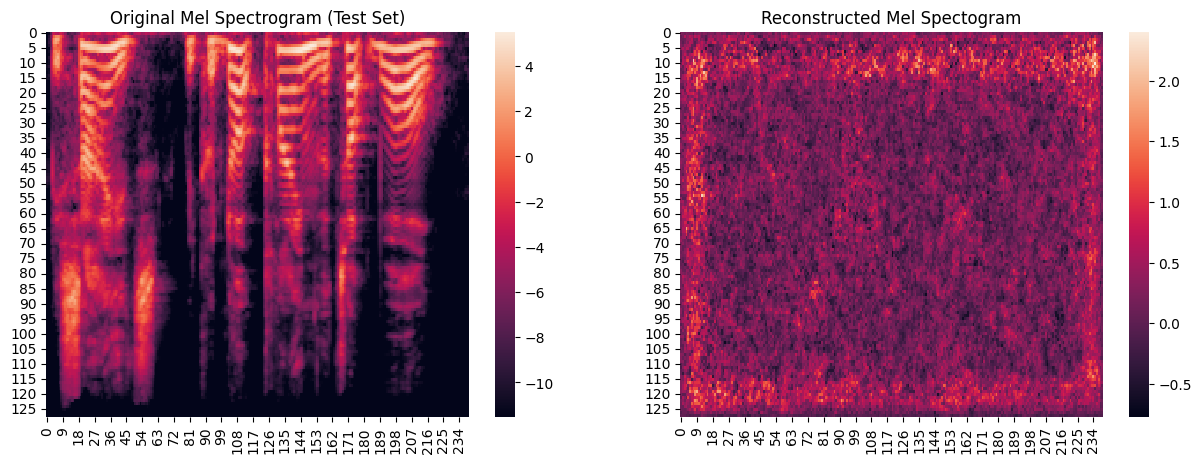

In [30]:
# SAMPLE WITHOUT TRAINING ON TEST SET
idx = 120

test_sample = test_dataset[idx][0].detach().cpu().numpy()
test_pred = autoencoder(test_dataset[idx].float().unsqueeze(0))[0][0][0].detach().cpu().numpy()

plot_comparation(test_sample, test_pred)

In [31]:
# Load with pretrained model
autoencoder.load_state_dict(torch.load("./pretrained_models/VAE/autoencoder_mode_compressed.pth"))

<All keys matched successfully>

MSE Score:  0.4428517785390528


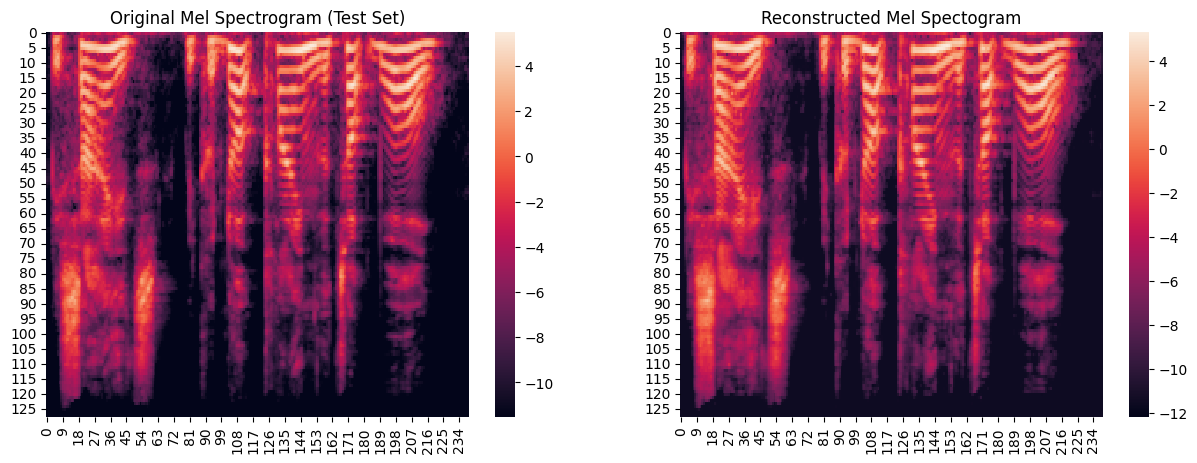

In [32]:
# SAMPLE AFTER TRAINING ON TEST SET
idx = 120

test_sample = test_dataset[idx][0].detach().cpu().numpy()
test_pred = autoencoder(test_dataset[idx].float().unsqueeze(0))[0][0][0].detach().cpu().numpy()

plot_comparation(test_sample, test_pred)

As you can see, there are a lot of significant change before and after training the VAE, especially on the MSE term. For the important note, these are the parameters used in order to train the best model so far:
```
########################
#   CRITERION PARAMS   #
########################

lr = 3e-5 (use cycle scheduler and adam optimizers)
lambda_adv = 0.1
lambda_recon = 1
lambda_kl = 0.4
lambda_fm = 0.5


##################
#   VAE PARAMS   #
##################

enc_config = {
                "in_channels": 1,
                "intermediate_channels": 128,
                "channel_multipliers":[1, 2, 4],
                "resblock_counts": 2,
                "attn_resolutions": [16],
                "dropout": 0.1,
                "resolution": 128,
                "z_channels": 16,
                "double_z": True
             }

dec_config = {
                "out_channels": 1,
                "intermediate_channels": 128,
                "channel_multipliers":[4, 2, 1],
                "resblock_counts": 2,
                "attn_resolutions": [16],
                "dropout": 0.1,
                "resolution": 128,
                "z_channels": 16,
                "double_z": False,
                "give_pre_end": False,
                "tanh_out": False
             }
```
It converges after 490.058 training steps. After this, we will continue to develop the diffusion modules and train it with $\phi$-probability data loading.


`--- End of 1st Research Checkpoint (13/08/2024) ---`

Transcription: 三つ、醜きエドの鬼を
MSE Score:  0.31116481667403983


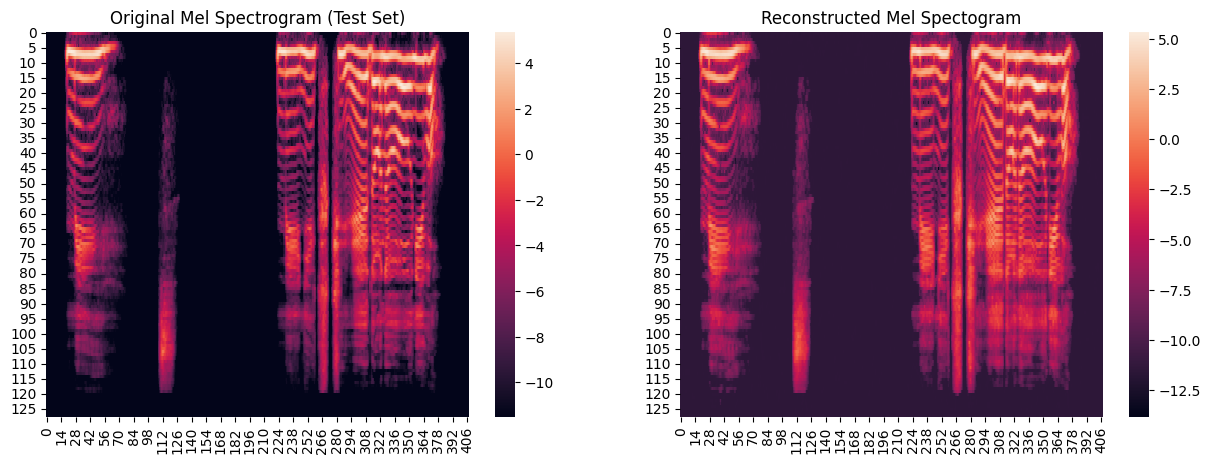

In [74]:
# Extension part for evaluating samples, don't mind this field

y, sr = librosa.load("./audio_samples/oni_44.1kHz.mp3", sr=44100)
y = get_padding_sample(y, from_torch=False)

oni_melspec = dynamic_range_compression(librosa.feature.melspectrogram(y=y, sr=sr))
tensor_oni = torch.tensor(oni_melspec).unsqueeze(0).unsqueeze(0)
pred_tensor_oni = autoencoder(tensor_oni.float().to("cuda"))

tensor_oni = tensor_oni.squeeze().detach().cpu().numpy()
pred_tensor_oni = pred_tensor_oni[0][0][0].detach().cpu().numpy()
print("Transcription: 三つ、醜きエドの鬼を")
plot_comparation(tensor_oni, pred_tensor_oni)

## PART 2: Building and Training the DDPM

(To be continued)